In [1]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from sklearn import cross_validation
import numpy as np
import pandas as pd
from sklearn import preprocessing

C:\Users\srikanth\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_excel("data0505.xlsx",header=0)
# clean up data
df = df.dropna(how = 'all')
df = df.fillna(0)
df = df.round(4)
df=df[df['Power']>=0]
df=df[df['SOC']>0]
df=df[df['SOH']>0]
df=df[df['SEI_delta']>0]
df.head()

,SOC,SOH,Power,T,SEI_after,SEI_delta
10,80,1.0,0.0526,23,0.0,44.8776
11,80,1.0,0.1579,23,0.0,46.1896
12,80,1.0,0.2632,23,0.0,47.5605
13,80,1.0,0.3684,23,0.0,48.9998
14,80,1.0,0.4737,23,0.0,50.4819


In [3]:
min_sei = min(df.iloc[:,5])
max_sei = max(df.iloc[:,5])
min_sei
max_sei
range_sei = max_sei-min_sei

# normalizaed
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.head()

,0,1,2,3,4,5
0,1.0,0.0,0.000000,0.0,0.0,0.067068
1,1.0,0.0,0.111146,0.0,0.0,0.153487
2,1.0,0.0,0.222293,0.0,0.0,0.243787
3,1.0,0.0,0.333333,0.0,0.0,0.338592
4,1.0,0.0,0.444480,0.0,0.0,0.436216


In [4]:
#x = np.array(df_normalized.iloc[:,0:3])#first three column are SoC, SoH, power
x = np.array(df_normalized.iloc[:,0:3])#first three column are SoC, SoH, power
y = np.array(df_normalized.iloc[:,5])#delta SEI
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
x, y, test_size=0.2, random_state=42)
total_len = X_train.shape[0]
total_len

4872

In [5]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Absolute Percentage error: %.4f"
      % np.mean(abs(regr.predict(X_test) - Y_test)/Y_test))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.4f' % regr.score(X_test, Y_test))

Coefficients: 
 [ 0.022439   -0.04618564  0.68645928]
Absolute Percentage error: 0.0715
Variance score: 0.9897


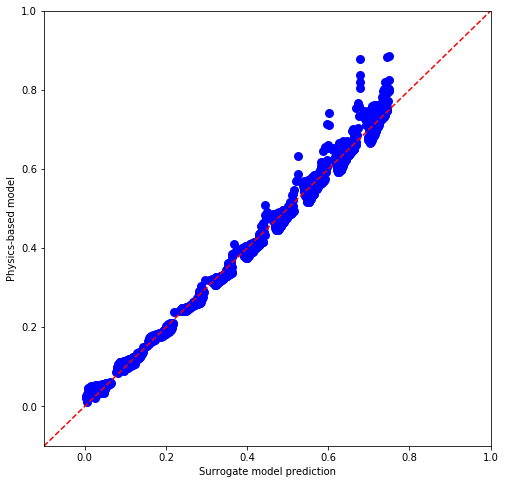

In [7]:

plt.figure(figsize=(8,8))

# Plot outputs
plt.scatter(regr.predict(X_test), Y_test, color='blue',
         linewidth=3)
plt.plot(range(-1,2),range(-1,2),'r--')
plt.ylim([-0.1,1])
plt.xlim([-0.1,1])
plt.xlabel('Surrogate model prediction')
plt.ylabel('Physics-based model')

#plt.savefig('linearY.png',transparent=True, dpi=800)
plt.show()


In [8]:
E = 1; # battery energy
P = 1; # battery power
T = 1800; # 1 hour, resolution 4 seconds
ts = 2/3600;

In [9]:
## Constant instruction signal
soc_arr = [0.2]; #initial SoC 0.2
soh_arr = [10**(-8)]; #initial SoH 1e-8
power_arr = [0.6]; #constant power instruction 0.6
for i in range(T):
    state = [soc_arr[i],soh_arr[i],power_arr[i]]
    state = np.array(state);
    delta_soh = ((regr.predict(state.reshape(1, -1))*range_sei)+min_sei)*10**(-16) #calculate the thickness change
    soh_new = soh_arr[-1]+delta_soh; # new SoH = previous SoH + thickness change
    soh_arr.append(soh_new)
    soc_new = soc_arr[-1]+(power_arr[-1]*ts)/E #new SoC = previous SoC + energy charged
    soc_arr.append(soc_new)
    power_new = 0.6
    power_arr.append(power_new)

In [10]:
soh_arr=np.array(soh_arr)


In [11]:

#linear = linear.apply(lambda i: ''.join(i))
#df.to_csv('list.csv', index=False)

In [12]:
linear = pd.DataFrame(soh_arr, columns=["delta"])
linear.to_csv('linear.csv')


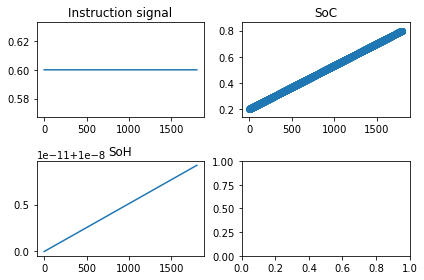

In [13]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(range(T), power_arr[0:T])
axarr[0, 0].set_title('Instruction signal')
#axarr[0, 0].xlabel('Time(s)')
#axarr[0, 0].xticks() 
axarr[0, 1].scatter(range(T), soc_arr[0:T])
axarr[0, 1].set_title('SoC')
axarr[1, 0].plot(range(T), soh_arr[0:T])
axarr[1, 0].set_title('SoH')
plt.subplots_adjust(left= 0.125, right = 0.9, bottom = 0.1, top = 0.9 , wspace = 0.2, hspace = 0.2 )
plt.tight_layout()
plt.show()

In [14]:
## Sine wave instruction signal
soc_arr = [0.6];
soh_arr = [10**(-8)];
power_arr = [0];
for i in range(T):
    if(power_arr[i]>=0):
        state = [soc_arr[i],soh_arr[i],power_arr[i]]
        state = np.array(state);
        delta_soh = ((regr.predict(state.reshape(1, -1))*range_sei)+min_sei)*10**(-16)
    else:
        delta_soh = 0
    soh_new = soh_arr[-1]+delta_soh;
    soh_arr.append(soh_new)
    soc_new = soc_arr[-1]+(power_arr[-1]*ts)/E
    soc_arr.append(soc_new)
    power_new = np.sin(2*np.pi*(i+1)*2/600)
    power_arr.append(power_new)

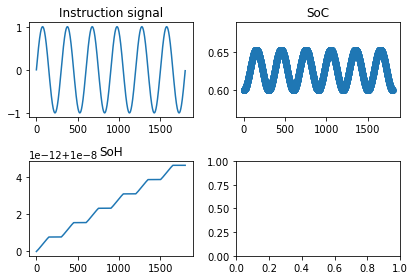

In [15]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(range(T), power_arr[0:T])
axarr[0, 0].set_title('Instruction signal')
axarr[0, 1].scatter(range(T), soc_arr[0:T])
axarr[0, 1].set_title('SoC')
axarr[1, 0].plot(range(T), soh_arr[0:T])
axarr[1, 0].set_title('SoH')
plt.subplots_adjust(left= 0.125, right = 0.9, bottom = 0.1, top = 0.9 , wspace = 0.2, hspace = 0.2 )
plt.tight_layout()
plt.show()
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots

In [16]:
soh_arr[-1]

array([  1.00046224e-08])

In [17]:
linear_sine=pd.DataFrame(np.array(soh_arr), columns=["delta"])
linear_sine.to_csv('linear_sine.csv')

In [18]:
linear_sine.to_csv('linear_sine.csv')

In [19]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from sklearn import cross_validation
import numpy as np
import pandas as pd
from sklearn import preprocessing
df = pd.read_excel("data0505.xlsx",header=0)
# clean up data
df = df.dropna(how = 'all')
df = df.fillna(0)
df = df.round(4)
df=df[df['Power']>=0]
df=df[df['SOC']>0]
df=df[df['SOH']>0]
df=df[df['SEI_delta']>0]
df.head()


,SOC,SOH,Power,T,SEI_after,SEI_delta
10,80,1.0,0.0526,23,0.0,44.8776
11,80,1.0,0.1579,23,0.0,46.1896
12,80,1.0,0.2632,23,0.0,47.5605
13,80,1.0,0.3684,23,0.0,48.9998
14,80,1.0,0.4737,23,0.0,50.4819


In [20]:
df2 = pd.read_excel("NYcityTaxi-Power.xlsx",header=0)
df2.head()

,Time (sec),normalized Power,Power(kW)
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0


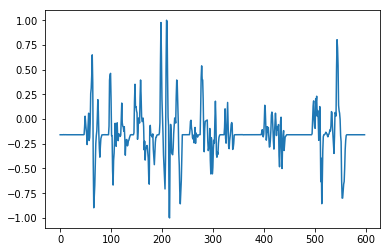

In [21]:
from sklearn.preprocessing import MinMaxScaler
df3 = df2['Power(kW)']
# normalizaed
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df2)
df_normalized = pd.DataFrame(np_scaled)
df_normalizedP= df_normalized[2]*2-1

#MinMaxScaler(copy=True, feature_range(0,1))
plt.plot(df2['Time (sec)'], df_normalizedP)
plt.show()


In [22]:
df2['Time (sec)'].tail

<bound method NDFrame.tail of 0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
12      12
13      13
14      14
15      15
16      16
17      17
18      18
19      19
20      20
21      21
22      22
23      23
24      24
25      25
26      26
27      27
28      28
29      29
      ... 
569    569
570    570
571    571
572    572
573    573
574    574
575    575
576    576
577    577
578    578
579    579
580    580
581    581
582    582
583    583
584    584
585    585
586    586
587    587
588    588
589    589
590    590
591    591
592    592
593    593
594    594
595    595
596    596
597    597
598    598
Name: Time (sec), Length: 599, dtype: int64>

In [45]:
E = 1; # battery energy
P = 1; # battery power
T = 598; #1800; # 1 hour, resolution 4 seconds
ts = 2/3600;
delta_soh_new=[];
## Sine wave instruction signal
soc_arr = [0.6];
soh_arr = [10**(-8)];
power_arr = [0];
for i in range(T):
    if(power_arr[i]>=0):
        state = [soc_arr[i],soh_arr[i],power_arr[i]]
        state = np.array(state);
        delta_soh = ((regr.predict(state.reshape(1, -1))*range_sei)+min_sei)*10**(-16)
    else:
        delta_soh = 0
    soh_new = soh_arr[-1]+delta_soh;
    delta_soh_new.append(delta_soh);
    soh_arr.append(soh_new)
    soc_new = soc_arr[-1]+(power_arr[-1]*ts)/E
    soc_arr.append(soc_new)
    power_new = df3[i] #np.sin(2*np.pi*(i+1)*2/600)
    power_arr.append(power_new)

In [46]:
#df3[T]
delta_soh_new
#np.sin(2*np.pi*(i+1)*2/600)

[array([  4.47663541e-15]),
 array([  4.47663541e-15]),
 array([  4.47663541e-15]),
 array([  4.47663541e-15]),
 array([  4.47663541e-15]),
 array([  4.47663541e-15]),
 array([  4.47663541e-15]),
 array([  4.47663541e-15]),
 array([  4.51748390e-15]),
 array([  4.47663615e-15]),
 array([  4.49586411e-15]),
 array([  4.49347512e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.47663681e-15]),
 array([  4.48224864e-15]),
 array([  4.48786157e-15]),
 array([  4.47663711e-15]),
 array([  4.47663711e-15]),
 array([  4.47663711e-15]),
 array([  4.47663711e-15]),
 array([  4.47663711e-15]),
 array([  4.47663711

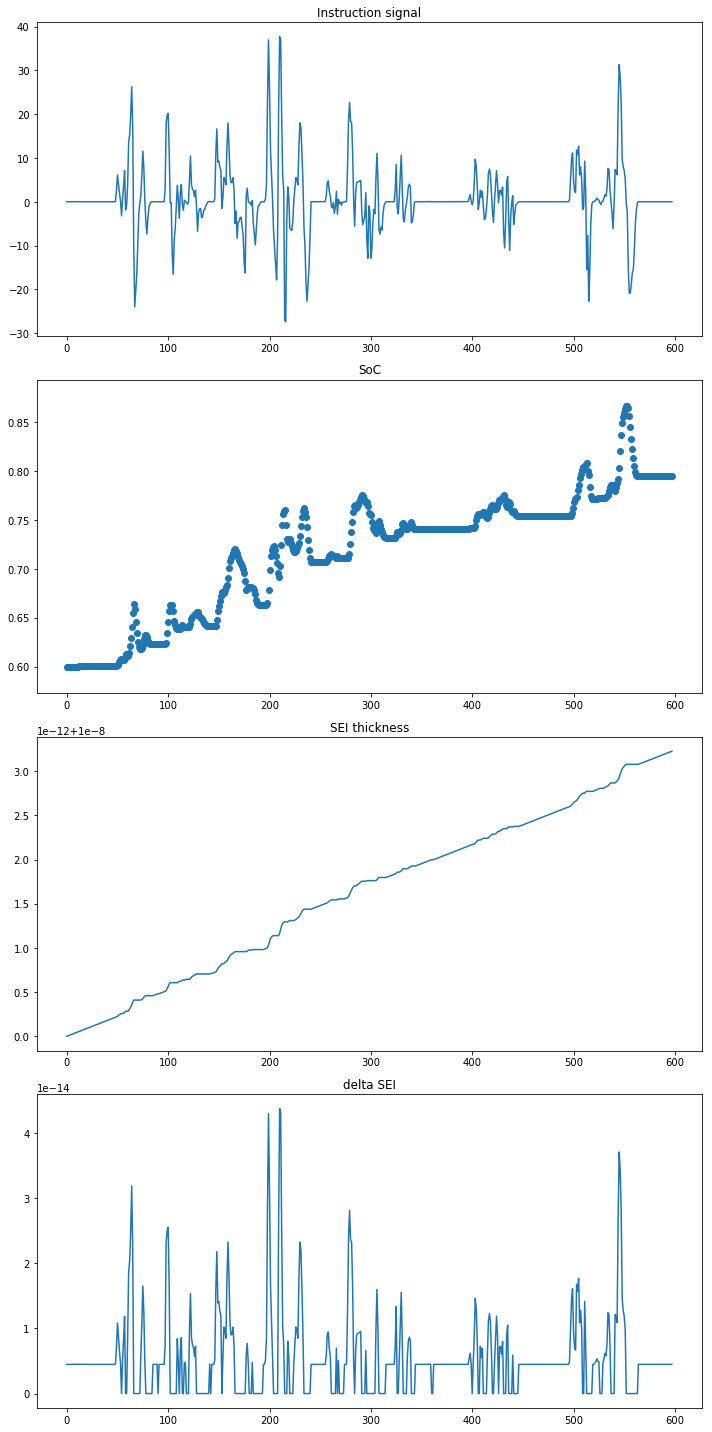

In [50]:
f, axarr = plt.subplots(4, figsize=(10,20))
#f.set_size(10,10)
axarr[0].plot(range(T), power_arr[0:T])
axarr[0].set_title('Instruction signal')
axarr[1].scatter(range(T), soc_arr[0:T])
axarr[1].set_title('SoC')
axarr[2].plot(range(T), soh_arr[0:T])
axarr[2].set_title('SEI thickness')
axarr[3].plot(range(T), delta_soh_new[0:T])
axarr[3].set_title('delta SEI')
plt.subplots_adjust(left= 0.125, right = 0.9, bottom = 0.1, top = 0.9 , wspace = 0.2, hspace = 0.2 )
plt.tight_layout()
plt.show()
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots